In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from research.strings import INSPECTION_ID, DATE, TARGET, PREDICTORS, OTHER_PREDICTORS
from research.evaluation import evaluate_model, show_roc, show_prc
from research.utils import get_crit_mat
from IPython.display import Image

In [7]:
df = pd.read_csv("data/inspections.csv")
print("Read {} records.".format(len(df)))

Read 18712 records.


In [38]:
BEST_SPLIT = 15762
d_train = df.query("{} <= {}".format(DATE, BEST_SPLIT))
d_test = df.query("{} > {}".format(DATE, BEST_SPLIT))
crit_train = get_crit_mat(d_train)
crit_test = get_crit_mat(d_test)
X_train = d_train[PREDICTORS]
X_test = d_test[PREDICTORS]

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

In [40]:
crit_train.sum(axis=0)

V1      35
V2     290
V3     608
V4      55
V5       0
V6     112
V7       5
V8     191
V9      52
V10     40
V11     79
V12    130
V13     26
V14     11
dtype: int64

In [41]:
code = "V2"
y_train = crit_train[:][code]
y_test = crit_test[:][code]
print("Train: P(V{0}) = {1:.3f}, N = {2}".format(code, y_train.mean(), y_train.sum()))
print("Test:  P(V{0}) = {1:.3f}, N = {2}\n".format(code, y_test.mean(), y_test.sum()))

print("Logistic Regression")
clf = LogisticRegression(solver="lbfgs", penalty="l2", class_weight="balanced", max_iter=2000)
clf.fit(X_train, y_train)
yh = clf.predict(X_test)
evaluate_model(y_test, yh)

Train: P(VV2) = 0.036, N = 290
Test:  P(VV2) = 0.036, N = 379

Logistic Regression
F1 Score = 0.11926
Precision = 0.06597
Recall = 0.62005


,Predicted +,Predicted -
Actual +,235,144
Actual -,3327,6885


AUROC = 0.712


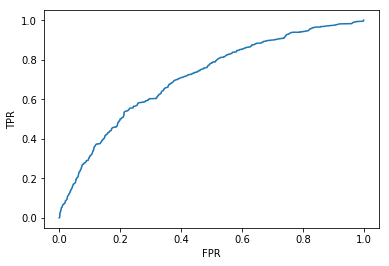

AUPRC = 0.091
Best F1 = 0.163 at threshold = 0.717


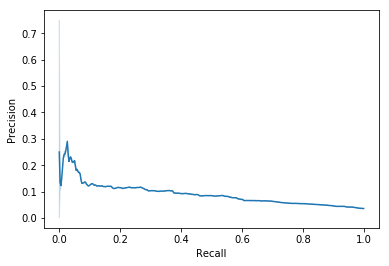

In [42]:
show_roc(clf, X_test, y_test)
show_prc(clf, X_test, y_test)

In [43]:
yh = (clf.predict_proba(X_test)[:,1] >= 0.693).astype(int)
evaluate_model(y_test, yh)

F1 Score = 0.15395
Precision = 0.10345
Recall = 0.30079


,Predicted +,Predicted -
Actual +,114,265
Actual -,988,9224


In [44]:
print("KNN")
clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(X_train, y_train)
yh = clf.predict(X_test)
evaluate_model(y_test, yh)

KNN
F1 Score = 0.00000
Precision = 0.00000
Recall = 0.00000


,Predicted +,Predicted -
Actual +,0,379
Actual -,0,10212


In [48]:
from sklearn.metrics import precision_recall_curve

def get_best_threshold(clf, X_test, y_test):
    y_score = clf.predict_proba(X_test)[:, 1]
    precs, recs, prc_t = precision_recall_curve(y_test, y_score)
    best_f1 = -1
    best_t = 2
    for p, r, t in zip(precs, recs, prc_t):
        f1 = (2 * p * r) / (p + r + 1e-10)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t, best_f1

In [49]:
res = []
regs = []
for i in range(1, 15):
    code = "V" + str(i)
    y_train = crit_train[:][code]
    y_test = crit_test[:][code]
    clf = None
    if i == 5:
        clf = DummyClassifier(strategy="most_frequent")
        clf.fit(X_train, [1 if i < 1 else 0 for i, y in enumerate(y_train)])
    else:
        clf = LogisticRegression(solver="lbfgs", penalty="l2", class_weight="balanced", max_iter=2000)
        clf.fit(X_train, y_train)
    yh = clf.predict(X_test)
    if yh.sum() == 0 and y_test.sum() == 0:
        prec = 1
        rec = 1
        f1 = 1
    else:
        f1, prec, rec, _, cm = evaluate_model(y_test, yh, verbose=False)
    tr, best_f1 = get_best_threshold(clf, X_test, y_test)
    regs.append(clf)
    res.append({
        "Code": code,
        "P(Train)": y_train.mean(),
        "P(Test)": y_test.mean(),
        "N(Train)": y_train.sum(),
        "N(Test)": y_test.sum(),
        "F1": f1,
        "Precision": prec,
        "Recall": rec,
        "Threshold": tr,
        "BestF1": best_f1
    })

In [52]:
info = [
    "Code",
    "P(Train)",
    "P(Test)",
    "N(Train)",
    "N(Test)",
    "F1",
    "Precision",
    "Recall",
    "Threshold",
    "BestF1"
]
viol_logs = pd.DataFrame(res)[info]
viol_logs

,Code,P(Train),P(Test),N(Train),N(Test),F1,Precision,Recall,Threshold,BestF1
0,V1,0.004310,0.004060,35,43,0.015634,0.007912,0.651163,0.783648,0.019565
1,V2,0.035710,0.035785,290,379,0.119259,0.065974,0.620053,0.716939,0.163331
2,V3,0.074868,0.077707,608,823,0.252812,0.155120,0.682868,0.731717,0.304845
3,V4,0.006773,0.002833,55,30,0.014041,0.007114,0.533333,0.947281,0.049383
4,V5,0.000000,0.000094,0,1,0.000000,0.000000,0.000000,0.000000,0.000189
5,V6,0.013791,0.010386,112,110,0.041754,0.021423,0.818182,0.836754,0.055088
6,V7,0.000616,0.001133,5,12,0.001166,0.000587,0.083333,0.000007,0.002535
7,V8,0.023519,0.024171,191,256,0.084500,0.044984,0.695312,0.868866,0.115254
8,V9,0.006403,0.008120,52,86,0.023290,0.011899,0.546512,0.594559,0.025026
9,V10,0.004926,0.003966,40,42,0.013612,0.006879,0.642857,0.810696,0.029197


In [53]:
import pickle
from research.metrics import to_inspection_daynum, show_metrics, compare_metrics

In [54]:
y_true = d_test[TARGET]
days = to_inspection_daynum(d_test["Inspection_Date"])
city = pickle.load(open("models/sklearn-glm.pkl", "rb"))
evaluate_model(y_true, city.predict(X_test))

F1 Score = 0.04084
Precision = 0.50769
Recall = 0.02128


,Predicted +,Predicted -
Actual +,33,1518
Actual -,32,9008


In [55]:
y_crits = np.array([clf.predict(X_test) for clf in regs])
y_pred = y_crits.max(axis=0)
evaluate_model(y_true, y_pred)

F1 Score = 0.28020
Precision = 0.16474
Recall = 0.93681


,Predicted +,Predicted -
Actual +,1453,98
Actual -,7367,1673


In [56]:
tr_arr = np.array([r["Threshold"] for r in res])
y_crits_proba = np.array([clf.predict_proba(X_test)[:,1] for clf in regs])
yt_mat = np.array([(y_crits_proba[:,i] >= tr_arr).astype(int) for i in range(len(X_test))]).T
y_pred_proba = yt_mat.max(axis=0)
evaluate_model(y_true, y_pred_proba)

F1 Score = 0.25548
Precision = 0.14645
Recall = 1.00000


,Predicted +,Predicted -
Actual +,1551,0
Actual -,9040,0


In [57]:
y_crits_proba[:,0]

array([ 0.3653285 ,  0.49668651,  0.56383592,  0.62145789,  0.        ,
        0.74837314,  0.04572783,  0.60493452,  0.56038036,  0.69983049,
        0.7294628 ,  0.56834216,  0.55968781,  0.04927243])

In [58]:
freq = crit_train.mean(axis=0)
np.dot(freq, y_crits_proba)

array([ 0.11539784,  0.1165016 ,  0.10468282, ...,  0.03554305,
        0.0276389 ,  0.07572383])

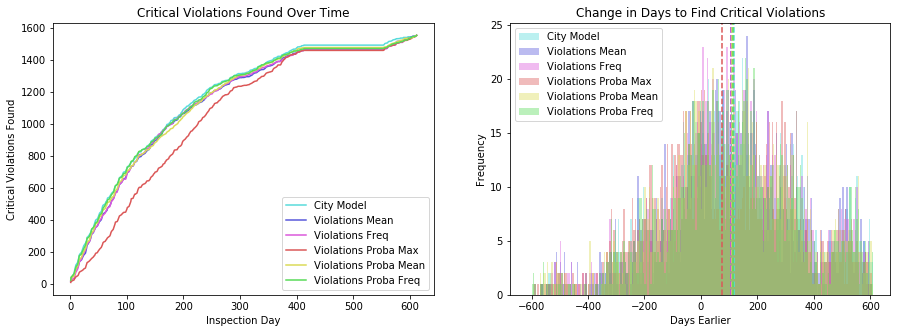

,Model,First Half,Mean Change,Std. Change
0,City Model,0.778,117.912,227.220
5,Violations Proba Freq,0.768,113.060,230.871
4,Violations Proba Mean,0.756,109.675,230.936
1,Violations Mean,0.754,106.690,230.525
2,Violations Freq,0.752,107.006,230.790
3,Violations Proba Max,0.686,75.772,237.941


In [62]:
all_models = [
    ("City Model", city.predict_proba(X_test)[:,1]),
    ("Violations Mean", y_crits.mean(axis=0)),
    ("Violations Freq", np.dot(crit_train.mean(axis=0), y_crits)),
    ("Violations Proba Max", y_crits_proba.max(axis=0)),
    ("Violations Proba Mean", y_crits_proba.mean(axis=0)),
    ("Violations Proba Freq", np.dot(crit_train.mean(axis=0), y_crits_proba)),
]
compare_metrics(y_true, days, all_models)

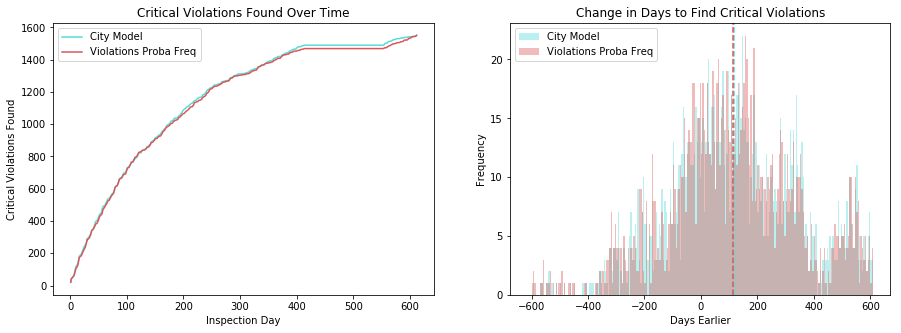

,Model,First Half,Mean Change,Std. Change
0,City Model,0.778,117.912,227.220
1,Violations Proba Freq,0.768,113.060,230.871


In [63]:
some_models = [
    ("City Model", city.predict_proba(X_test)[:,1]),
    ("Violations Proba Freq", np.dot(crit_train.mean(axis=0), y_crits_proba)),
]
compare_metrics(y_true, days, some_models)

In [66]:
SPLIT_DATE = 16252
d_train_orig = df.query("{} <= {}".format(DATE, SPLIT_DATE))
d_test_orig = df.query("{} > {}".format(DATE, SPLIT_DATE))
X_test_orig = d_test_orig[PREDICTORS]
y_test_orig = d_test_orig[TARGET]
print("Original Test Set: N = {0}, P({1}) = {2:.3f}".format(len(X_test_orig), TARGET, y_test_orig.mean()))

Original Test Set: N = 1637, P(criticalFound) = 0.158


In [76]:
y_crits_orig = np.array([clf.predict(X_test_orig) for clf in regs])
y_pred_orig = y_crits_orig.max(axis=0)
evaluate_model(y_test_orig, y_pred_orig)

F1 Score = 0.29283
Precision = 0.17446
Recall = 0.91085


,Predicted +,Predicted -
Actual +,235,23
Actual -,1112,267


In [70]:
y_crits_proba_orig = np.array([clf.predict_proba(X_test_orig)[:,1] for clf in regs])
yt_mat_orig = np.array([(y_crits_proba_orig[:,i] >= tr_arr).astype(int) for i in range(len(X_test_orig))]).T
y_pred_proba_orig = yt_mat_orig.max(axis=0)
evaluate_model(y_test_orig, y_pred_proba_orig)

F1 Score = 0.27230
Precision = 0.15761
Recall = 1.00000


,Predicted +,Predicted -
Actual +,258,0
Actual -,1379,0


In [71]:
crit_train_orig = get_crit_mat(d_train_orig)
freq_orig = crit_train_orig.mean(axis=0)
np.dot(freq_orig, y_crits_proba_orig)

array([ 0.14313816,  0.11905332,  0.08593161, ...,  0.03513869,
        0.0278164 ,  0.07704238])

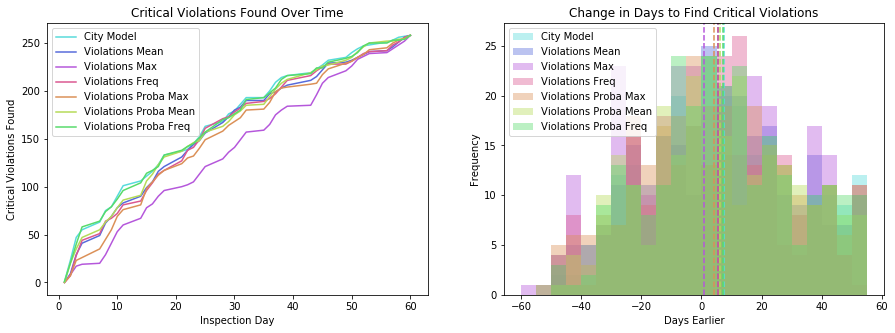

,Model,First Half,Mean Change,Std. Change
0,City Model,0.690,7.438,25.156
1,Violations Mean,0.678,5.581,25.652
6,Violations Proba Freq,0.671,7.128,24.602
3,Violations Freq,0.671,5.570,25.090
5,Violations Proba Mean,0.659,6.306,25.195
4,Violations Proba Max,0.640,4.306,25.880
2,Violations Max,0.539,0.690,25.066


In [74]:
all_models_orig = [
    ("City Model", city.predict_proba(X_test_orig)[:,1]),
    ("Violations Mean", y_crits_orig.mean(axis=0)),
    ("Violations Max", y_crits_orig.max(axis=0)),
    ("Violations Freq", np.dot(crit_train_orig.mean(axis=0), y_crits_orig)),
    ("Violations Proba Max", y_crits_proba_orig.max(axis=0)),
    ("Violations Proba Mean", y_crits_proba_orig.mean(axis=0)),
    ("Violations Proba Freq", np.dot(crit_train_orig.mean(axis=0), y_crits_proba_orig)),
]
days_orig = to_inspection_daynum(d_test_orig[DATE])
compare_metrics(y_test_orig, days_orig, all_models_orig)

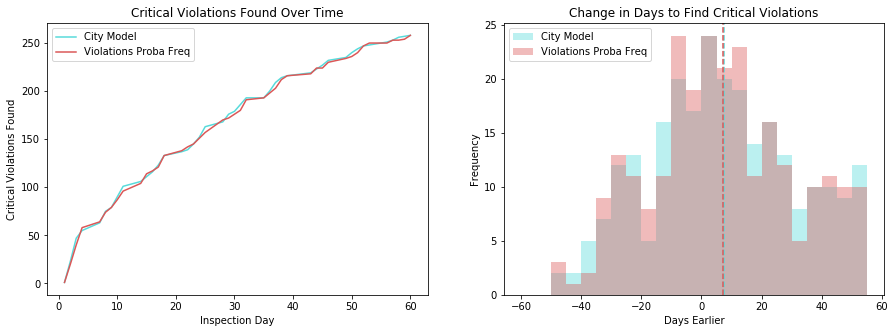

,Model,First Half,Mean Change,Std. Change
0,City Model,0.690,7.438,25.156
1,Violations Proba Freq,0.671,7.128,24.602


In [73]:
some_models_orig = [
    ("City Model", city.predict_proba(X_test_orig)[:,1]),
    ("Violations Proba Freq", np.dot(crit_train_orig.mean(axis=0), y_crits_proba_orig))
]
compare_metrics(y_test_orig, days_orig, some_models_orig)